# Example: Readout Bottleneck

### Load a Model and Normalize an Example Input

In [1]:
from torchvision import models, transforms
from attribution_bottleneck.utils.misc import prepare_image
from PIL import Image

device = "cuda"  # Change to "cuda" to run on GPU
model = models.resnet50(pretrained=True).eval()
ex_image = Image.open("monkeys.jpg")
ex_input = prepare_image(ex_image)
ex_target = 382  # 382: squirrel monkey

### Initialize Distribution Estimator
We use a precalculated estimation of mean and standard deviation of the output of the second block in the ResNet-30, which is called "layer_2" in the torchvision package.

In [2]:
from attribution_bottleneck.bottleneck.estimator import *
estimators = [
    ReluEstimator(model.layer1),
    ReluEstimator(model.layer2),
    ReluEstimator(model.layer3),
    ReluEstimator(model.layer4),
    GaussianEstimator(model.fc),
]
group = EstimatorGroup(model, estimators)
group.load("weights/estimator_resnet50_1,2,3,4,fc.torch")

### Initialize Readout Bottleneck Reader

In [3]:
from attribution_bottleneck.bottleneck.readout_bottleneck import ReadoutBottleneckB
from attribution_bottleneck.attribution.readout_bottleneck import ReadoutBottleneckReader

# Create a readout bottleneck using the estimator and the model
bottleneck_layer = ReadoutBottleneckB.load_path(model, group.layers(), "weights/readout_resnet50_epoch35.torch")

# Initialize the attribution method of using this layer
reader = ReadoutBottleneckReader(model, model.layer1, bottleneck_layer)

## Generate and Normalize Heatmaps
To visualize the generated heatmaps, we need to normalize them to [0,1]

In [4]:
model.eval()
heatmap = reader.heatmap(ex_input, ex_target)
result = model(ex_input).argmax().item()
print("Result class is", result, "which is", ex_target==result)

Result class is 382 which is True


## Compare Heatmap Images

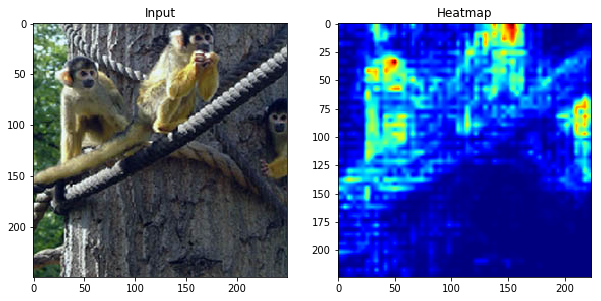

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,8))

# Draw the original input
plt.subplot(1, 2, 1)
plt.imshow(np.asarray(ex_image))
plt.title("Input")

# Draw the heatmap
plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap="jet")
plt.title("Heatmap")

plt.show()